In [1]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print('클래스 레이블: ', np.unique(y))

클래스 레이블:  [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=1, stratify=y)

In [3]:
print(np.bincount(y), np.bincount(y_train), np.bincount(y_test))

[50 50 50] [35 35 35] [15 15 15]


StandardScaler


In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(max_iter=40, eta0=0.1, tol=1e-3, random_state=1)
ppn.fit(X_train_std,y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=40, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [7]:
from sklearn.metrics import accuracy_score
print('정확도: %.2f'%accuracy_score(y_test,y_pred))

정확도: 0.98


In [8]:
print('정확도: %.2f' % ppn.score(X_test_std, y_test))

정확도: 0.98


In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s','x','o','^','v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black' 
                   )

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolors='black', alpha=1.0, linewidths=1, marker='o',
                   s=100, label='test_set')
        

        

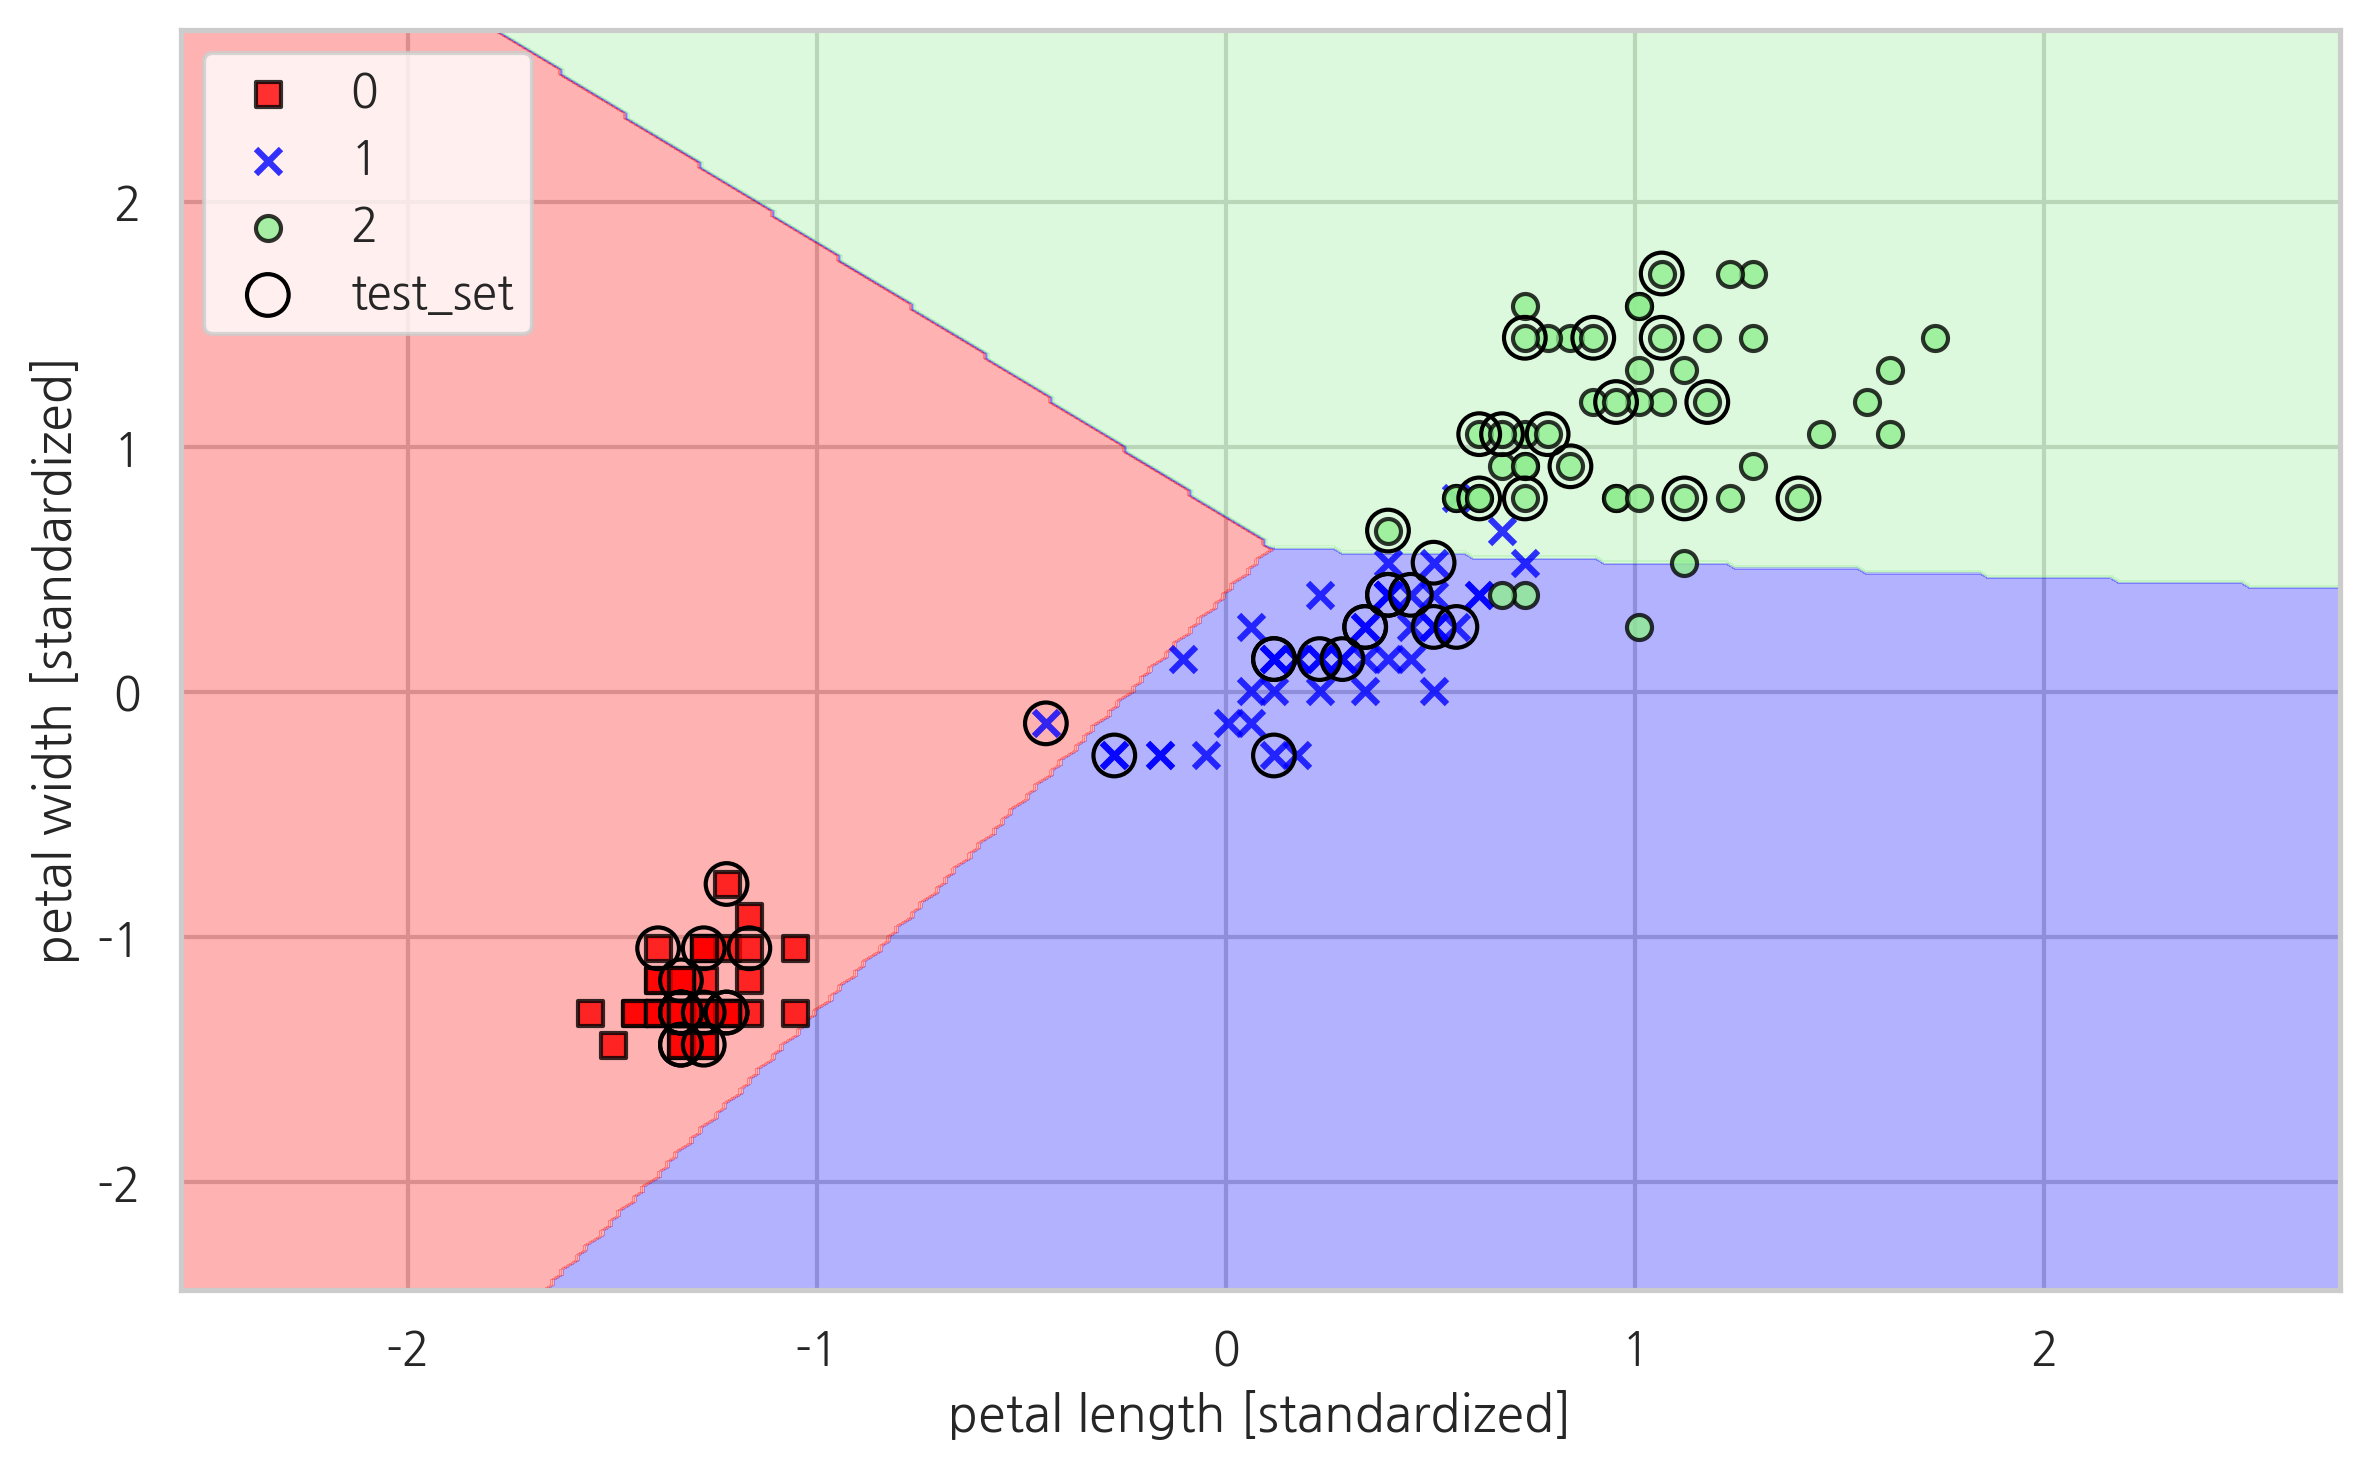

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined_std = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,y=y_combined_std,classifier=ppn,test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

시그모이드 함수
$$ \phi(z) = \frac{1}{1+e^{-z}} $$

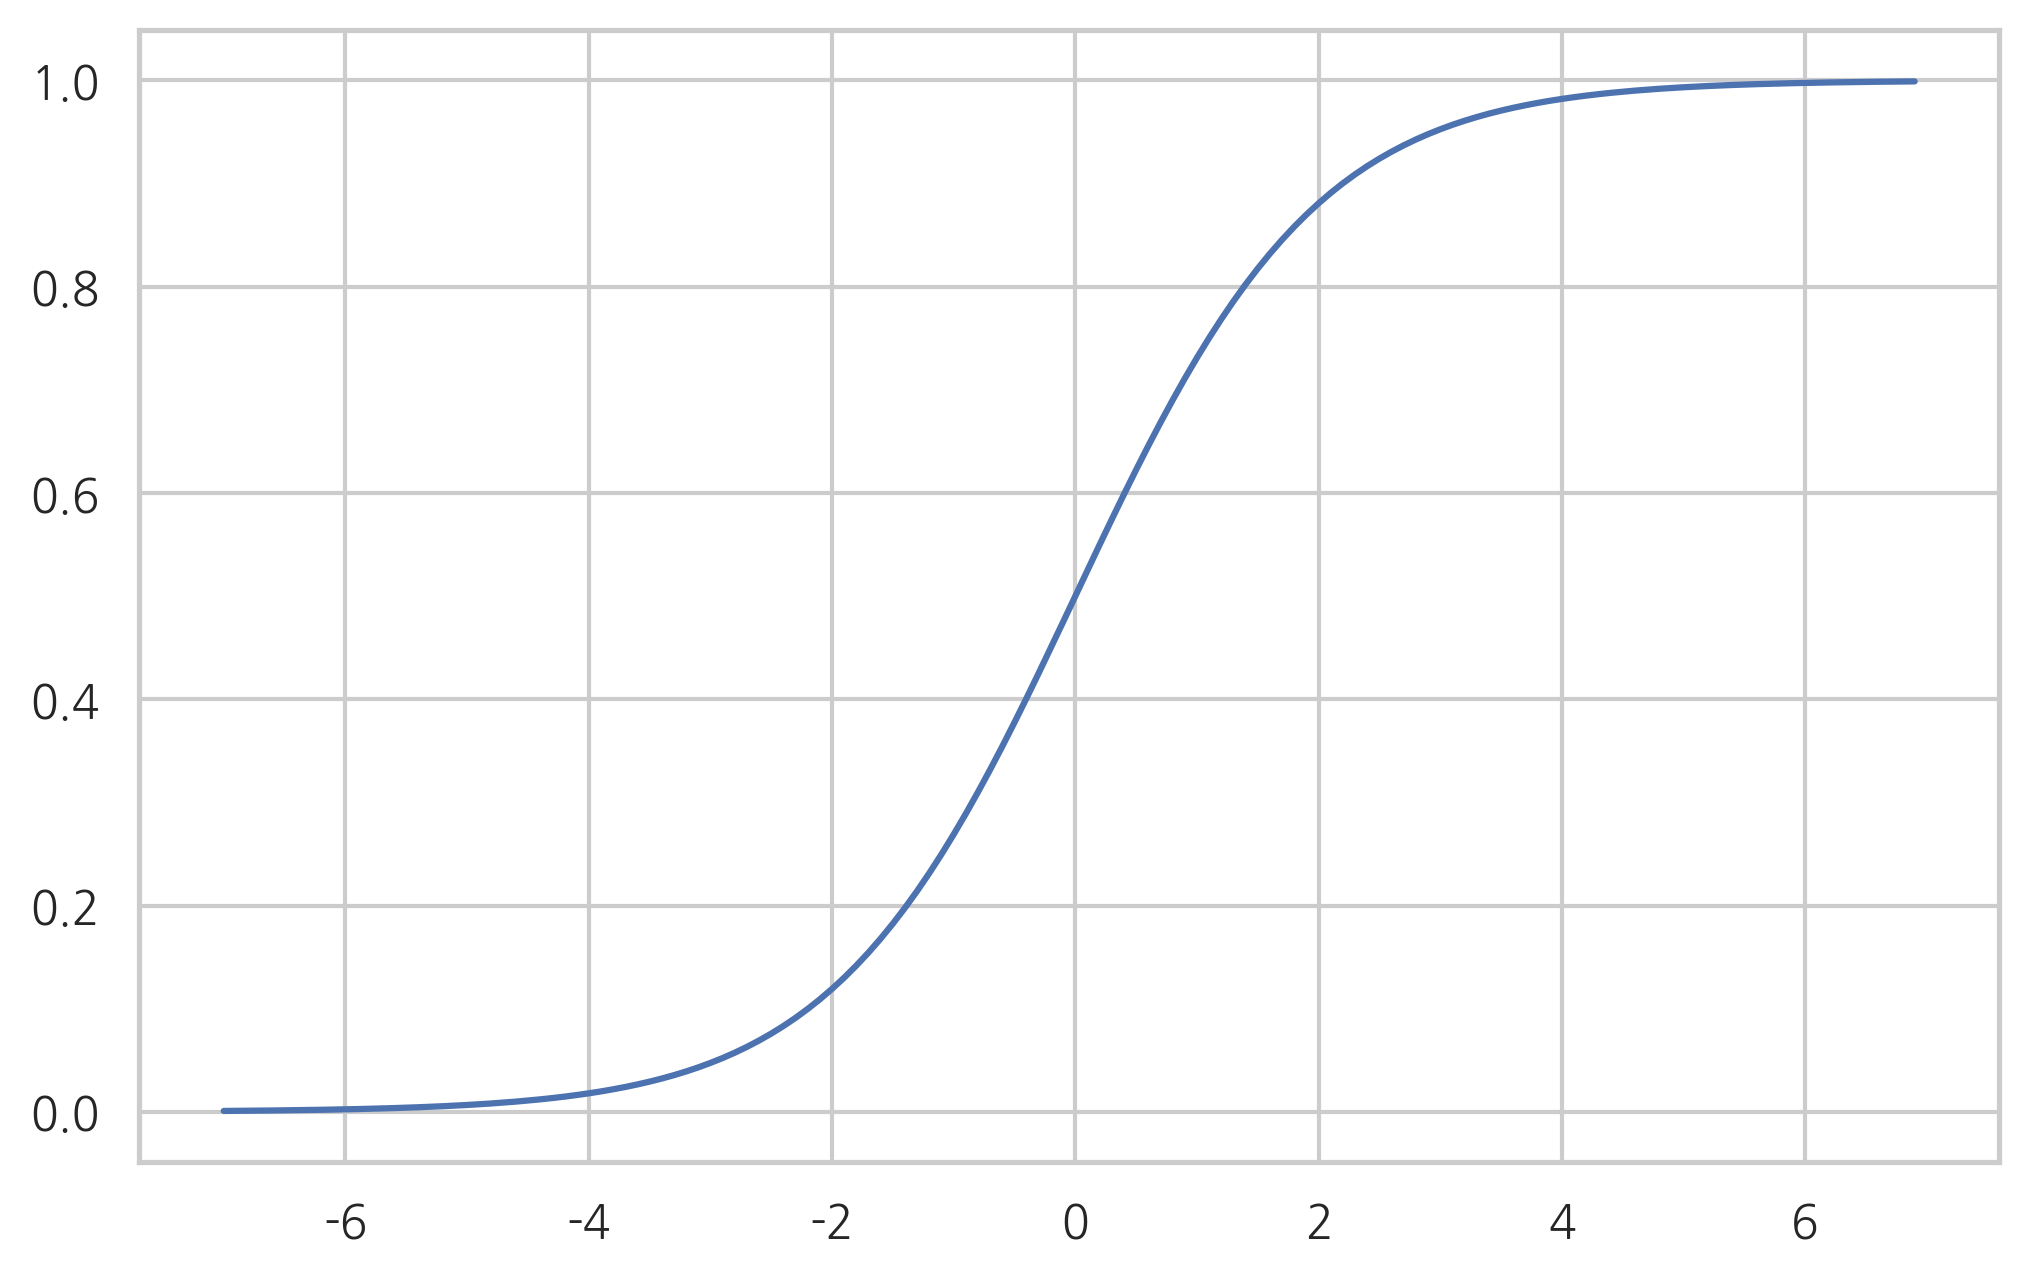

In [13]:
def sigmoid(z):
    return 1.0/(1.0 +np.exp(-z))

z = np.arange(-7,7,0.1)
phi_z = sigmoid(z)
plt.plot(z,phi_z)
plt.show()

#### 로지스틱 비용 함수의 가중치 학습
아달린의 제곱 오차합비용
$$ \mathit J(w) = \sum_{i}\frac{1}{2}(\phi(z^{(i)})-y^{(i)})^2$$

로지스틱 회귀 모델 (likelihood) L
$$\mathit L(w) = P(y|x;w) = \prod_{i=1}^{n} P(y^{(i)}|x^{(i)};w)=\prod_{i=1}^{n}(\phi(z^{(i)}))^{y^{(i)}}(1-\phi(z^{(i)}))^{1-y^{(i)}}$$

$$l(w) = log L(w) = \sum_{i=1}^{n}[y^{(i)}log(\phi(z^{(i)}))+(1-y^{(i)})log(1-\phi(z^{(i)}))]$$


$$ J(w) = \sum_{i=1}^{n}[ -y^{(i)}log(\phi(z^{(i)}))-(1-y^{(i)})log(1-\phi(z^{(i)})) ]$$

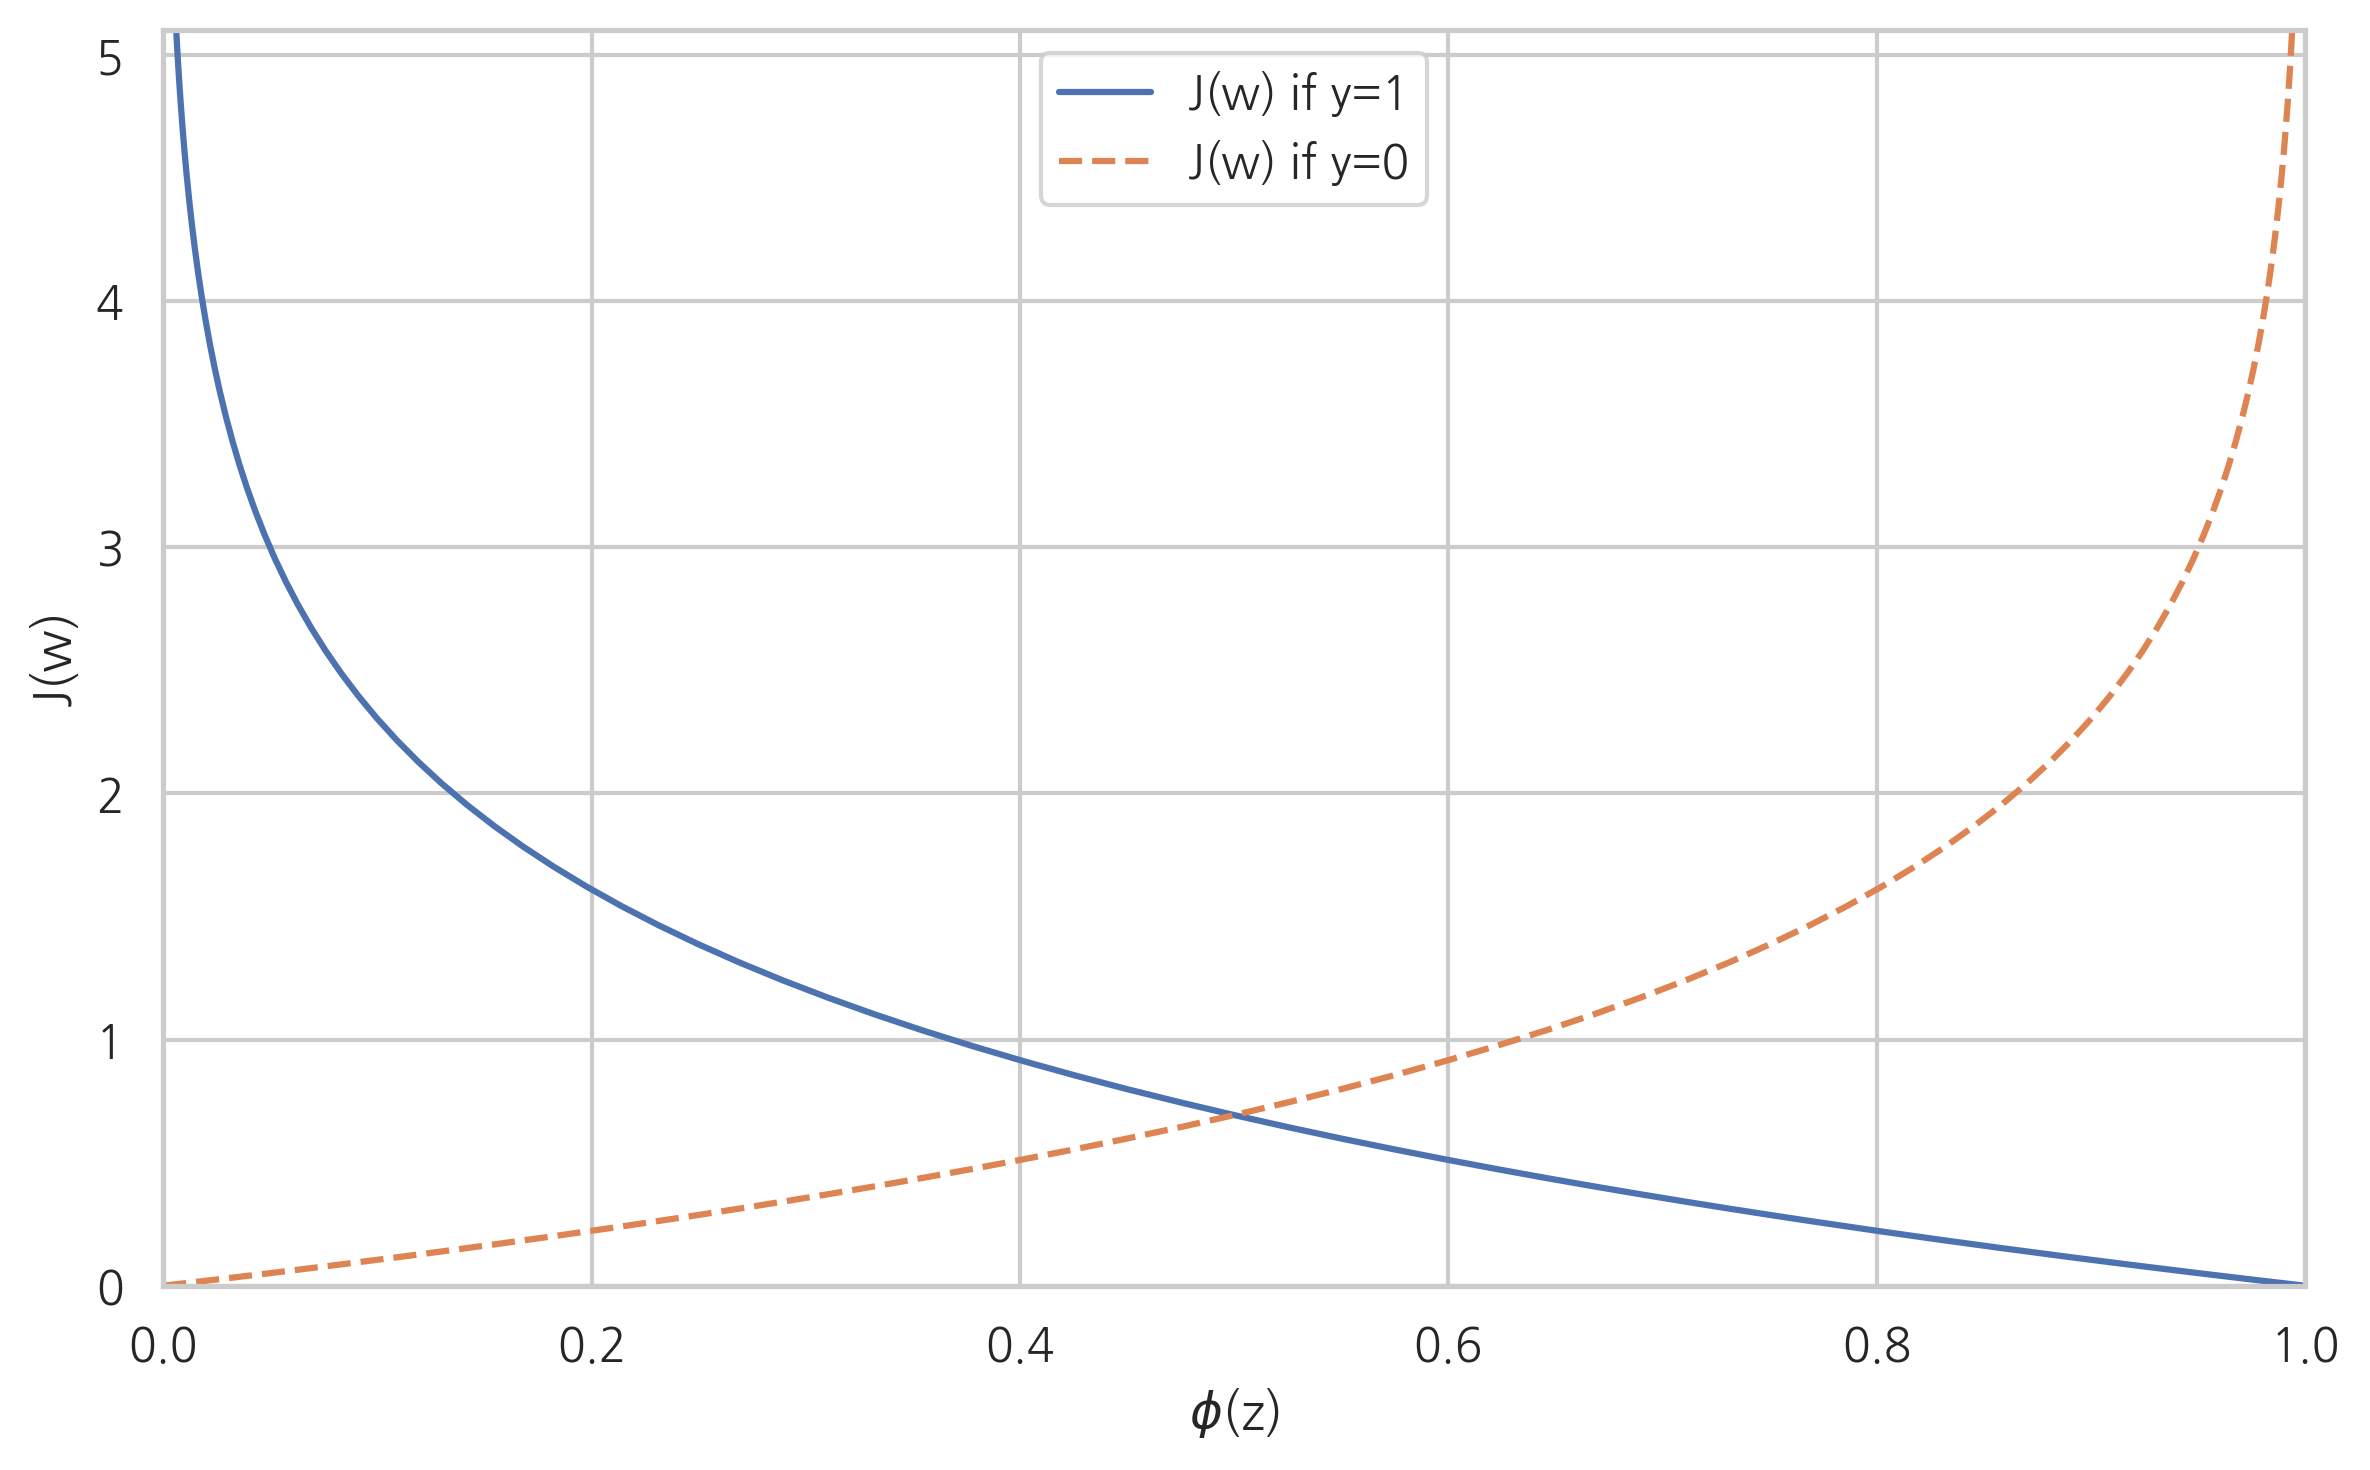

In [14]:
def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1-sigmoid(z))

z=np.arange(-10,10,0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0,1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [19]:
class LogtisticRegressionGD(object):
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            cost = (-y.dot(np.log(output)) - ((1-y).dot(np.log(1-output))))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1./(1. + np.exp(-np.clip(z, -250,250)))
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    

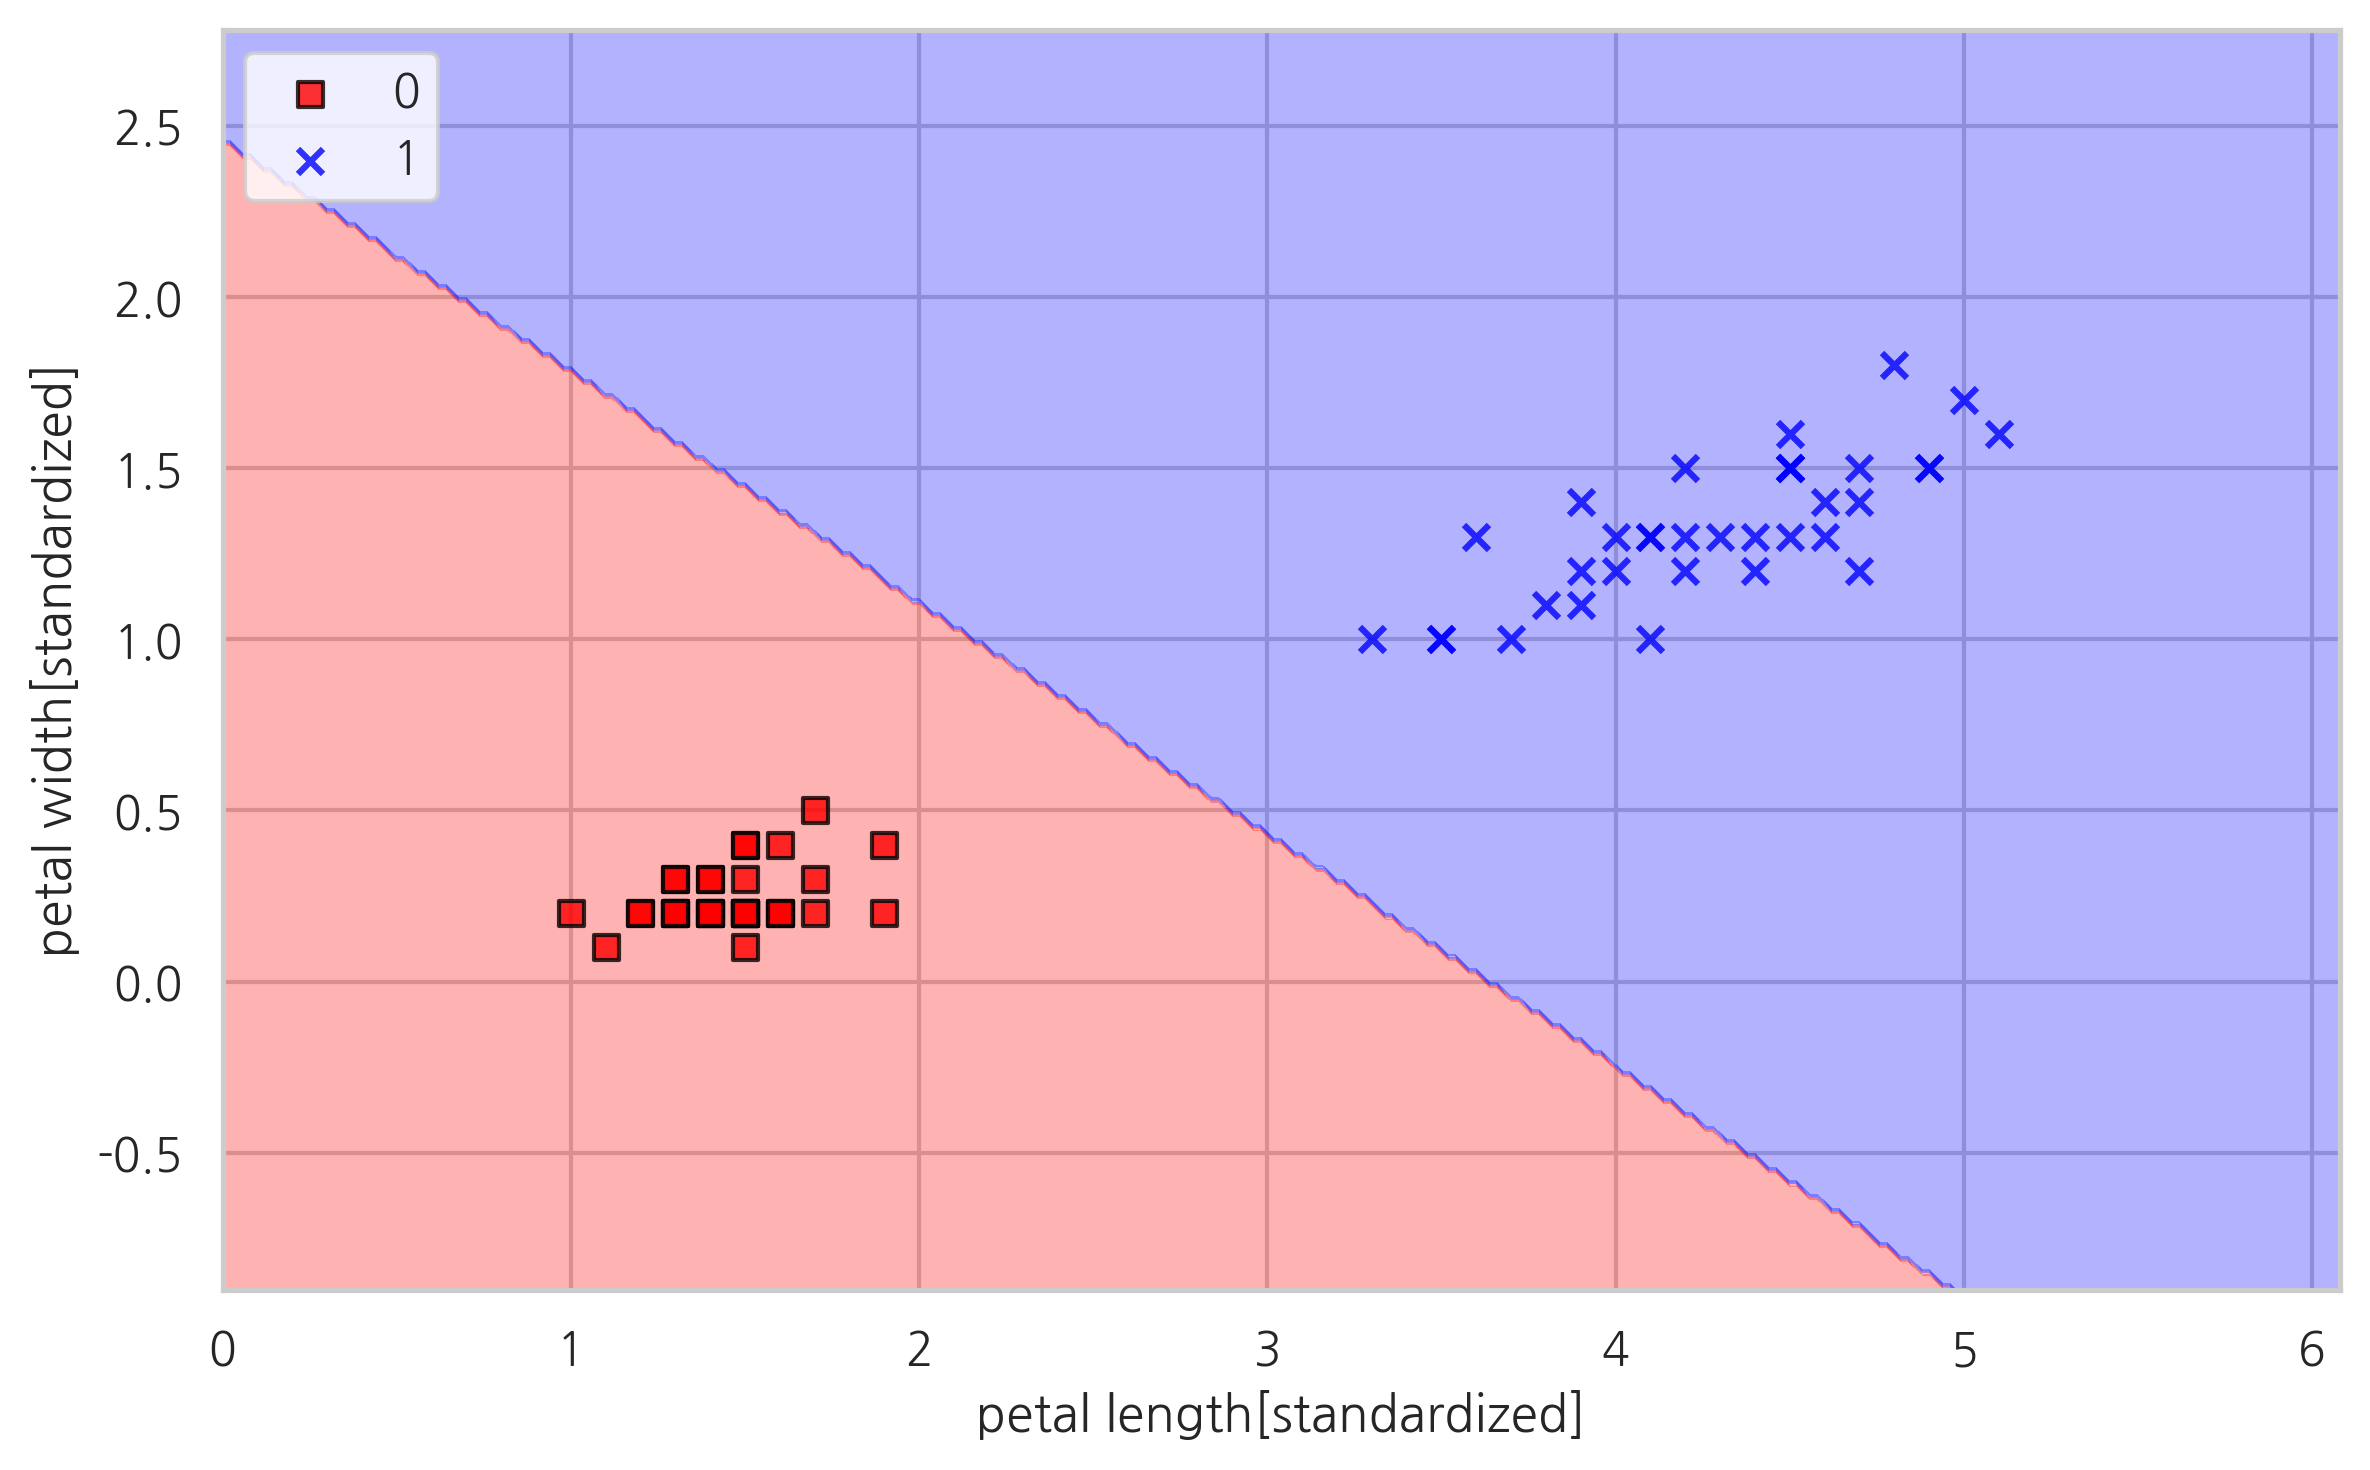

In [21]:
X_train_01_subset = X_train[(y_train == 0)|(y_train == 1)]
y_train_01_subset = y_train[(y_train == 0)|(y_train == 1)]
lrgd = LogtisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length[standardized]')
plt.ylabel('petal width[standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

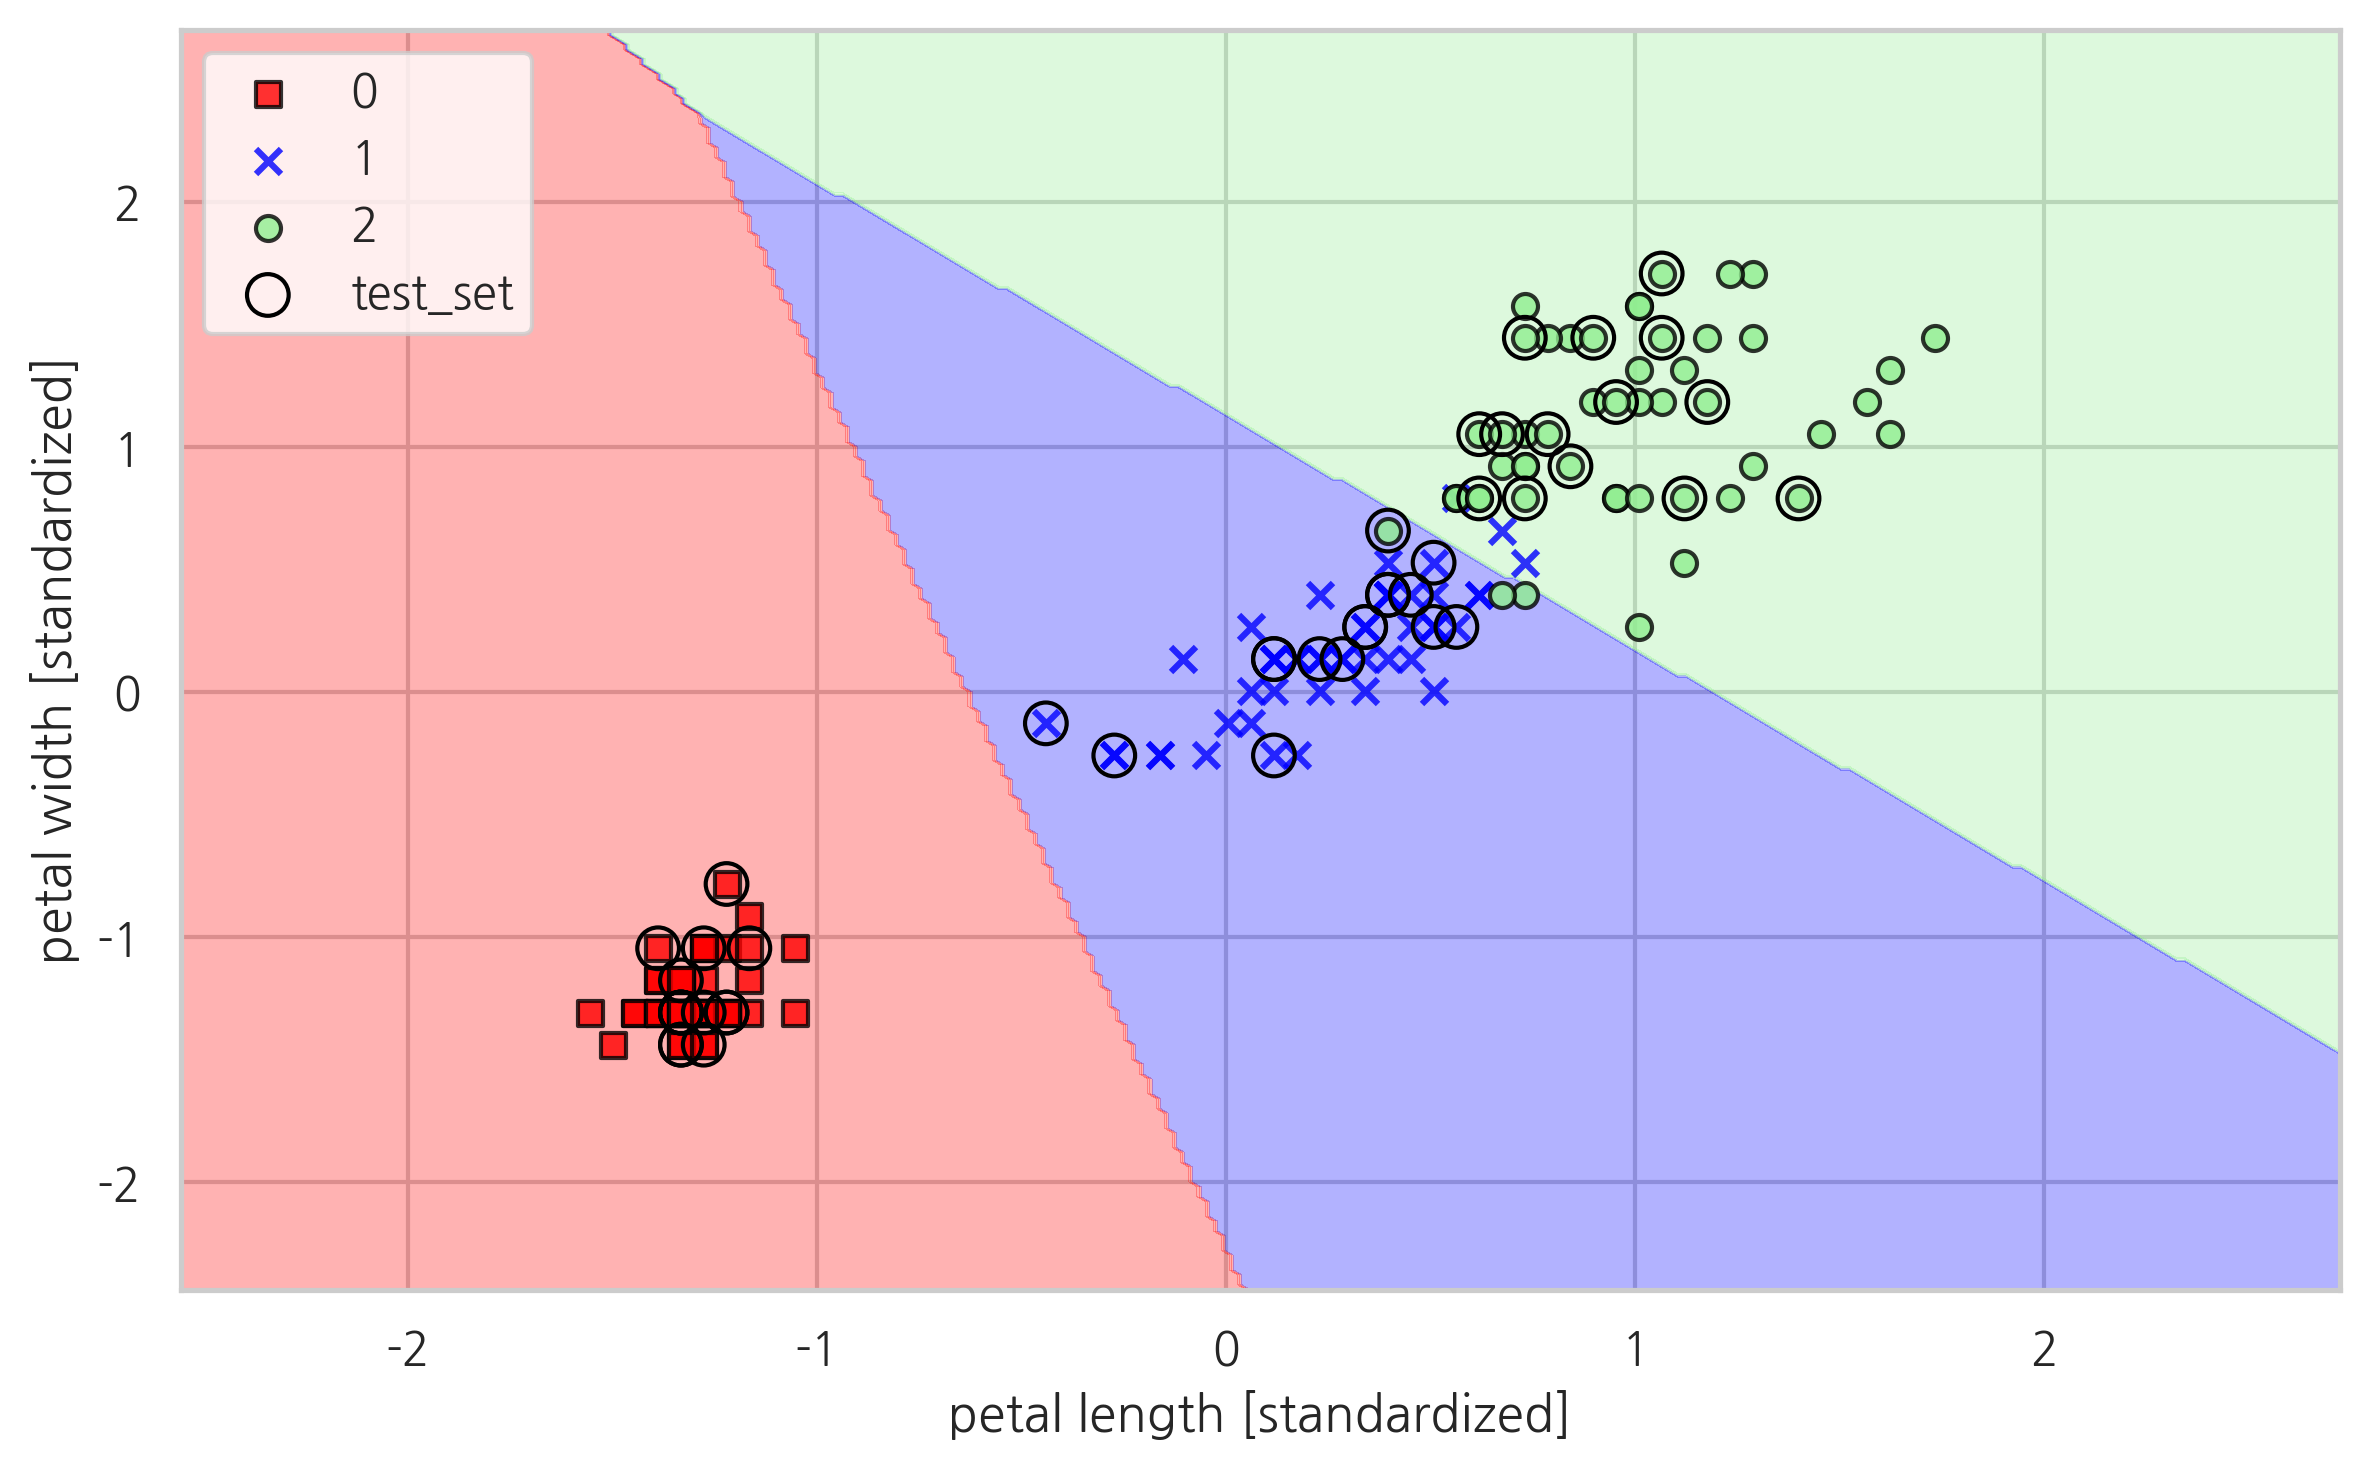

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', multi_class='auto', C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [25]:
lr.predict_proba(X_test_std[:3,:])

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13]])

In [26]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0])

In [31]:
X_test_std[0,:].reshape(1,-1).shape

(1, 2)